# GPOD Five Minutes Tutorial

This introductory tutorial shows how to make and apply a car detector using gpod. The [UIUC Image Database for Car Detection](http://cogcomp.cs.illinois.edu/Data/Car/) is used as example dataset.
The following folder structure is assumed:
```
data
|-cars
  |-TestImages
  |-TrainImages
    |-pos
    |-neg
```
Let's start with importing all we need.

In [1]:
import gpod
import skimage.io
import skimage.feature
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

## 1. How to create detector object

As gpod is designed to be general purpose, it has no prior on data loading, feature extraction, and classification approach. So before creating a detector object you need to define loader function to load image data, descriptor function to extract features from image patches, and sklearn-like classifier object (must implement methods: **fit** and **predict_proba**). In most cases it is straightforward.

In [2]:
def my_loader(path):
    return skimage.io.imread(path, as_grey=True)

def my_descriptor(img):
    return skimage.feature.hog(img, orientations=8, pixels_per_cell=(10,10), cells_per_block=(1,1), visualise=False)

my_classifier = sklearn.linear_model.LogisticRegression()

Let's create detector object. You need to pass loader, descriptor, classifier, and frame; in this case frame is the shape of images in train dataset. Let other parameters keep default values. By default the detector is multiscale and uses non-maximum suppression. For detailes see API Reference.

In [3]:
detector = gpod.Detector2D(my_loader, my_descriptor, my_classifier, (40, 100))

## 2. How to fit detector

It is straightforward to fit detector from folder in file system, gpod automatically catches names of object classes, in this case: 'pos' and 'neg'.

In [4]:
detector.fit('data/cars/TrainImages')

Detector2D(loader=<function my_loader at 0x7fc9dacff7b8>,
            descriptor=<function my_descriptor at 0x7fc9dacff950>,
            classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
            frame=(40, 100),
            frame_step=0.25,
            scale_step=0.75,
            max_scale_steps=100)

Note: method **fit** can accept images from other data sources and supports data augmentation.

## 3. How to detect cars on image(s)

You can easily detect objects using **detect** method, draw frames around objects using **detect_mark** method, and crop detected object images using **detect_crop** method; **detect** returns Mark2D object discussed below, **detect_mark** returns numpy.ndarray, **detect_crop** returns list of numpy.ndarray. Let's see some examples.

In [5]:
mo = detector.detect('data/cars/TestImages/test-9.pgm', 'pos')
print(mo.get_list_of_frames())

[(30, 100, 40, 100, 0.5938202547675574, 'pos'), (30, 0, 40, 100, 0.9941315779724504, 'pos')]


Here each item is (x, y, size_x, size_y, probability, class_name)

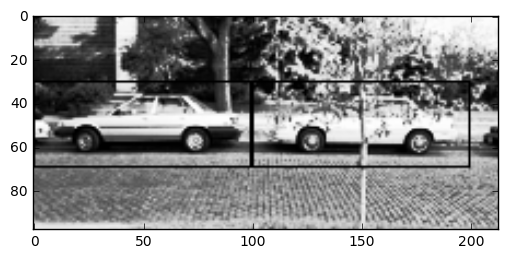

In [6]:
img = detector.detect_mark('data/cars/TestImages/test-9.pgm', 'pos')
plt.imshow(img, cmap='gray')

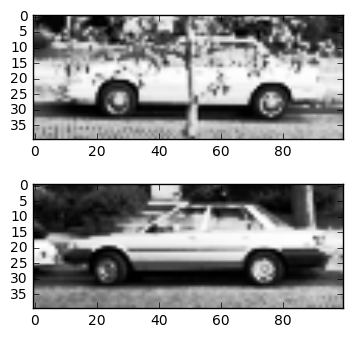

In [7]:
list_of_imgs = detector.detect_crop('data/cars/TestImages/test-9.pgm', 'pos')
_, ax = plt.subplots(2,1, figsize=(4,4))
for i, img in enumerate(list_of_imgs):
    ax[i].imshow(img, cmap='gray')

Of course, gpod can accept images as numpy arrays.

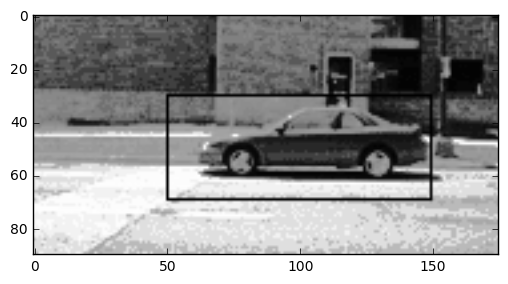

In [8]:
preloaded = my_loader('data/cars/TestImages/test-2.pgm')
img = detector.detect_mark(preloaded, 'pos')
plt.imshow(img, cmap='gray')

gpod supports batch processing, Detector2D object has **batch_detect**, **batch_detect_mark**, and **batch_detect_crop** methods. For detailes see API Reference. Here is example:

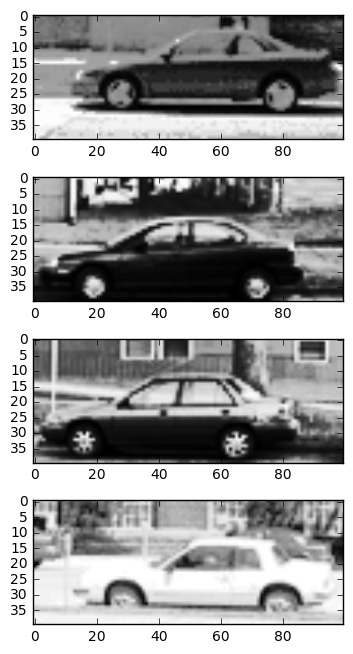

In [9]:
preloaded_imgs = [my_loader('data/cars/TestImages/test-2.pgm'),
                  my_loader('data/cars/TestImages/test-3.pgm'),
                  my_loader('data/cars/TestImages/test-4.pgm')
                 ]
list_of_imgs = detector.batch_detect_crop(preloaded_imgs, 'pos', flatten=True)

_, ax = plt.subplots(4, 1, figsize=(4,8))
for i, img in enumerate(list_of_imgs):
    ax[i].imshow(img, cmap='gray')


## 4. What is Mark2D object
Mark2D object is a container for data on detected objects on image. It stores class name, coordinates on image, size, and probability of identity for each object detected on image. Mark2D supports slicing by string or set of strings to extract object data of some class or classes, and slicing by float range to extract object data of probabilities in specified range. Mark2D object is also used to perform postprocessing of object data, e.g. non-maximum suppression is implemented in Mark2D.

Let's see what happens if non-maximum suppression turned off.

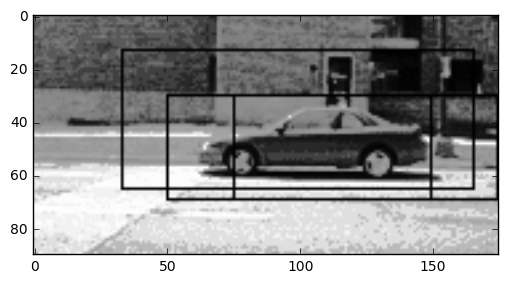

In [10]:
img = detector.detect_mark('data/cars/TestImages/test-2.pgm', 'pos', post_processing='None')
plt.imshow(img, cmap='gray')

In [11]:
mo = detector.detect('data/cars/TestImages/test-2.pgm', 'pos', post_processing='None')
print(mo.get_list_of_frames())

[(30, 50, 40, 100, 0.8288109780302966, 'pos'), (30, 75, 40, 100, 0.5495571515697939, 'pos'), (13, 33, 53, 133, 0.7725927809997168, 'pos')]


So, now we have Mark2D object "mo" with 3 items. Let's see what Mark2D object can.

In [12]:
print(mo.apply_nms(overlap_threshold=0.3).get_list_of_frames())

[(30, 50, 40, 100, 0.8288109780302966, 'pos')]


In [13]:
print(mo[0.7:].get_list_of_frames())

[(30, 50, 40, 100, 0.8288109780302966, 'pos'), (13, 33, 53, 133, 0.7725927809997168, 'pos')]


In [14]:
print(mo['pos'].get_list_of_frames())

[(30, 50, 40, 100, 0.8288109780302966, 'pos'), (30, 75, 40, 100, 0.5495571515697939, 'pos'), (13, 33, 53, 133, 0.7725927809997168, 'pos')]


In [15]:
print(mo['neg'].get_list_of_frames())

[]


In [16]:
print(mo[{'pos', 'neg'}].get_list_of_frames())

[(30, 50, 40, 100, 0.8288109780302966, 'pos'), (30, 75, 40, 100, 0.5495571515697939, 'pos'), (13, 33, 53, 133, 0.7725927809997168, 'pos')]
